In [1]:
pip install pyserial

In [2]:
#to reload old data comment out file definition and run this cell to refresh memory
date=f"05Aug2025"
#f"05Aug2025"

file="robot_log_"+date
filename=file+ ".csv"
txtfile=file+ ".txt"

In [3]:
print(filename)
print(date)
print(txtfile)

robot_log_05Aug2025.csv
05Aug2025
robot_log_05Aug2025.txt


In [12]:
#main code for collecting and storing data
import serial
from datetime import datetime, date

# change this to your actual serial port and baud rate
port = 'COM5'  
baud_rate = 115200

#pull current time and make new files
date=datetime.now().strftime('%d%b%Y')
#file= f"robot_log_{date}"
filename= file + ".csv"
txtfile= file + ".txt"

try:
    ser = serial.Serial(port, baud_rate, timeout=1)
    print(f"opened serial port: {port} at {baud_rate} baud")

    with open(filename, 'w') as f:
        print("logging started (Ctrl+C to stop)")
        while True:
            line = ser.readline().decode('utf-8').strip()
            if line:
                print(line)       # print to console for live view
                f.write(line + '\n')  # save to file

except KeyboardInterrupt:
    print("\nlogging stopped")
except Exception as e:
    print(f"Error: {e}")
finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()
        print("serial port closed")
        

Error: could not open port 'COM5': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)


In [5]:
#for raw encoder position data I had to add 0's to the csv so it could read right
import csv

input_path = filename
output_path = "robot_log_05Aug2025_fixed.csv"
expected_columns = 7

with open(input_path, "r") as infile, open(output_path, "w", newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    for row in reader:
        if not row:
            continue

        expanded_row = []
        for cell in row:
            expanded_row.extend(cell.split(','))

        if len(expanded_row) < expected_columns:
            expanded_row += ['0'] * (expected_columns - len(expanded_row))
        elif len(expanded_row) > expected_columns:
            expanded_row = expanded_row[:expected_columns]

        writer.writerow([val.strip() for val in expanded_row])


In [6]:
import pandas as pd

# load the CSV
df=pd.read_csv(output_path)

# save as TXT (default tab-delimited, change sep if needed)
df.to_csv(txtfile, sep= ',', index=False) # or sep= '\t' ',' or sep=' ' depending on what you want


wrapped offset [tics]
[6. 6. 6. ... 2. 3. 3.]
angle per tic [rads]
6.283185307179586
theta 1 wrapped [rads]
[37.69911184 37.69911184 37.69911184 ... 12.56637061 18.84955592
 18.84955592]
theta1 all [rads]
[37.69911184 37.69911184 37.69911184 ... 37.69911184 37.69911184
 37.69911184]


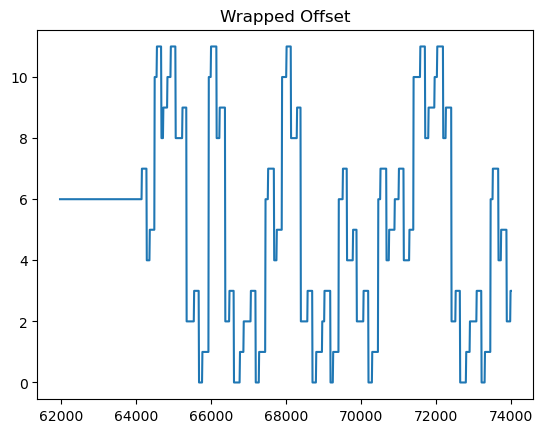

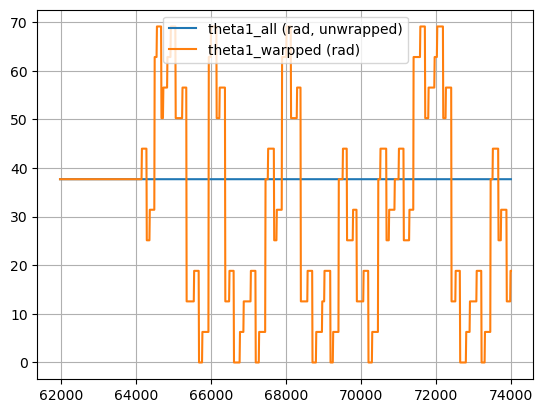

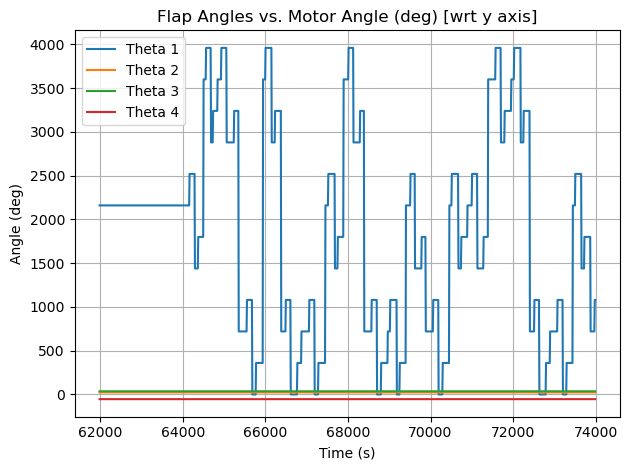

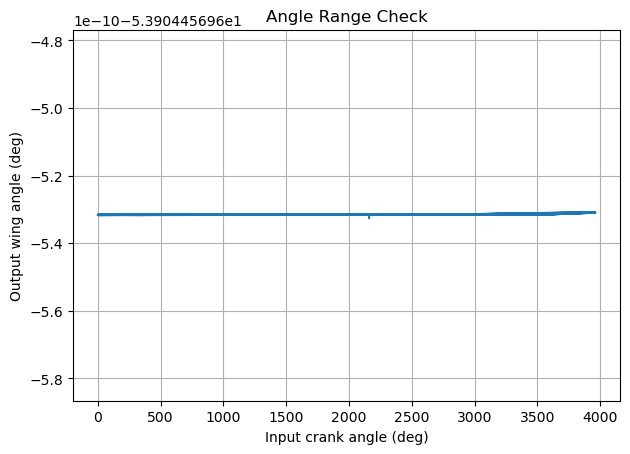

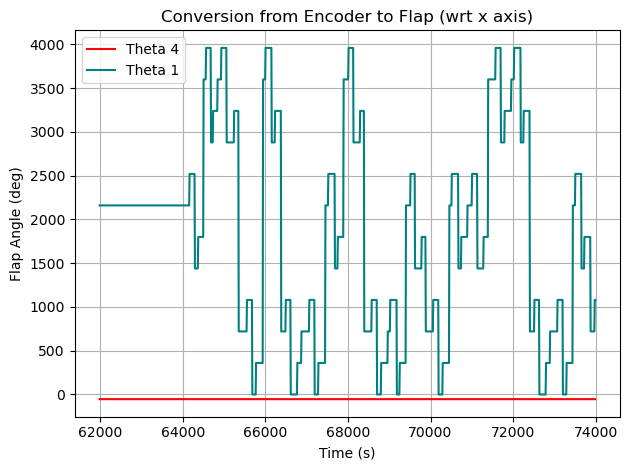

[-53.90445697 -53.90445697 -53.90445697 ... -53.90445697 -53.90445697
 -53.90445697]
[53.90445697 53.90445697 53.90445697 ... 53.90445697 53.90445697
 53.90445697]


In [10]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

# link lengths (mm)
L1 = 5.5  # input
L2 = 11.55  # coupler
L3 = 7.70  # output
L4 = 9.90  # fixed base

# pull data from file and store it
#key:  (time, right crank angle, left crank angle, pwr A, pwr B)
#data = np.loadtxt('robot_log.txt', delimiter='\t', usecols=(0, 1, 2))  # ignore trailing commas (I messed up in my original print function)
data=pd.read_csv(txtfile, delimiter=",", header=None)
#data=pd.read_csv(txtfile, sep=r"\s+", header=None)

# extract each variable column from file KEY:(time, right count, left count, right bound degrees, left bound degrees, pwr right, prw left)
time = data.iloc[:, 0].to_numpy()
right_count= data.iloc[:, 1].to_numpy()
left_count= data.iloc[:, 2].to_numpy()
right_theta_deg = data.iloc[:, 3].to_numpy()
left_theta_deg = data.iloc[:, 4].to_numpy()

#adding unwrapped ticks and offset
tics=right_count
offset=tics+6 #starting offset in ticks
wrapped_offset=np.mod(offset, 12) #find what fraction of a rotation it's at

# pick a wing here (sub left for left trial)
encoder_all = 2*np.pi*wrapped_offset #for the solver in radians
encoder_all_unwrapped = 2*np.pi*angle_per_tic*offset

#conversion to properly limited units
#theta1_all = np.unwrap(encoder_all_unwrapped)       # rest of code assumes rads, continuous angle
#theta1_wrapped=np.mod(encoder_all_unwrapped, 2*np.pi)

theta1_wrapped = encoder_all
#(2*np.pi/ 12) * (offset % 12)
theta1_deg_wrap=np.rad2deg(theta1_wrapped)

#unwrapped continuous for plotting
theta1_all = np.unwrap(theta1_wrapped)


print("wrapped offset [tics]")
print(wrapped_offset)
print("angle per tic [rads]")
print(angle_per_tic)
print("theta 1 wrapped [rads]")
print(theta1_wrapped)
print("theta1 all [rads]")
print(theta1_all)

plt.figure()
plt.plot(time, wrapped_offset)
plt.title("Wrapped Offset")

# storage for outputs
theta2_output = []
theta3_output = []
theta4_output= []
theta4_y = []

#guessing a starting value for values of theta 2 and 3 
initial_guess=[np.radians(60), np.radians(30)]

#write key functions from calculations
def sys_equations(unknowns, theta1_wrapped,L1,L2,L3,L4):
    theta2, theta3= unknowns
    equation1=L1*np.cos(theta1_wrapped)+L2*np.cos(theta2)-L3*np.cos(theta3)-L4
    equation2=L1*np.sin(theta1_wrapped)+L2*np.sin(theta2)-L3*np.sin(theta3)
    return[equation1,equation2]

# loop through each input angle and find the unknowns
for t1 in theta1_wrapped:
        #fsolve is (func, x0, args) 
        solution=fsolve(sys_equations, initial_guess, args=(t1,L1,L2,L3,L4))
        theta2, theta3=solution
        #final output flap angle wrt x and y axis
        theta4=np.radians(90)-theta3 
        theta4_yaxis=np.radians(180)-theta3
        theta2_output.append(theta2)
        theta3_output.append(theta3)
        theta4_output.append(theta4)
        theta4_y.append(theta4_yaxis)
        
        #continuously update to test other values
        initial_guess=solution
        
#test value to make sure loading from file
#print("Theta2 (first 5):", theta2_output[:5])

#plot in radians

#plt.figure(1)
#plt.plot(time, theta1_wrapped, label='Theta 1')
#plt.plot(time, theta2_output, label='Theta 2')
#plt.plot(time, theta3_output, label='Theta 3')
#plt.plot(time, theta4_output, label='Theta 4')
#plt.xlabel('Time (s)')
#plt.ylabel('Angle (rad)')
#plt.title('Four-Bar Linkage Output Angles vs. Input Angle(rad)')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()


#conversion back to original degrees to check graph (has to be after trig)
deg_theta1= theta1_deg_wrap
deg_theta2=np.rad2deg(theta2_output)
deg_theta3=np.rad2deg(theta3_output)
deg_theta4=np.rad2deg(theta4_output)
deg_theta4_y=np.rad2deg(theta4_y)
theta4_adjusted=deg_theta4

plt.figure()
#plt.plot(time, encoder_all, label="encoder_all (rad, wrapped 0–2π)")
plt.plot(time, theta1_all, label="theta1_all (rad, unwrapped)")
plt.plot(time, theta1_wrapped, label="theta1_warpped (rad)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(2)
plt.plot(time, deg_theta1, label='Theta 1')
plt.plot(time, deg_theta2, label='Theta 2')
plt.plot(time, deg_theta3, label='Theta 3')
plt.plot(time, -deg_theta4, label='Theta 4')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Flap Angles vs. Motor Angle (deg) [wrt y axis]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# angle range check plot
plt.plot(deg_theta1, -theta4_adjusted)
plt.xlabel('Input crank angle (deg)')
plt.ylabel('Output wing angle (deg)')
plt.title('Angle Range Check')
plt.grid(True)
plt.tight_layout()
plt.show()

#output plot
plt.figure(3)
plt.plot(time, -theta4_adjusted, label='Theta 4', color= 'red')
plt.plot(time, deg_theta1, label='Theta 1', color= 'teal')
plt.xlabel('Time (s)')
plt.ylabel('Flap Angle (deg)')
plt.title('Conversion from Encoder to Flap (wrt x axis)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print(-deg_theta4)
print(theta4_adjusted)


#export raw and calculated to csv file (KEY: time in ms, output angle in deg)
df_raw=pd.DataFrame({
    0:time,
    1:right_count,
    2:left_count,
    3:right_theta_deg,
    4:left_theta_deg
})

df = pd.DataFrame({
    0: time,
    1: deg_theta4,
})

df_offset = pd.DataFrame({
    0:time,
    1:right_count,
    2:deg_theta1,
    3:deg_theta4,
})

title1=f"{date}both_raw_encoders.csv"
title2=f"{date}flap_output_left.txtwwww"
title3=f"{date}offset.txt"

# save to CSV without index and header (matlab-fix)
df_raw.to_csv(title1, index=False, header=False)
df.to_csv(title2, index=False, header=False)
df_offset.to_csv(title3)


In [22]:
import pandas as pd

df = pd.read_csv('both_raw_encoders.csv')  # load CSV
df.to_csv('both_raw_encoders.txt', index=False)  # save as TXT with commas
